# DeepLab inference for car part segmentation

In [1]:
#@title import
import os
import sys
import numpy as np
import tensorflow as tf

from urllib.request import urlopen
from matplotlib import gridspec
from matplotlib import pyplot as plt
from PIL import Image
from io import BytesIO

sys.path.append("/content/dohai90/workspaces/models/research")

In [2]:
#@title Helper methods
class DeepLabModel(object):
    """Class to load deeplab model and run inference. """
    
    INPUT_TENSOR_NAME = "ImageTensor:0"
    OUTPUT_TENSOR_NAME = "SemanticPredictions:0"
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = "frozen_inference_graph"
    
    def __init__(self, graph_path):
        """Load pretrained deeplab model"""
        self.graph = tf.Graph()
        self.graph_def = None
        
        with tf.gfile.Open(graph_path, 'rb') as f:
            self.graph_def = tf.GraphDef.FromString(f.read())
            
        if self.graph_def is None:
            raise RuntimeError('Cannot read inference graph')
            
        with self.graph.as_default():
            tf.import_graph_def(self.graph_def, name='')
            
        self.sess = tf.Session(graph=self.graph)
        
    def run(self, image):
        """Run inference on a single image
        
        Args:
            image: A PIL.Image object, raw input image
        
        Returns:
            resized_image: RGB image resized from original input image
            seg_map: Segmentation map of 'resized_image'
        """
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(self.OUTPUT_TENSOR_NAME, feed_dict={self.INPUT_TENSOR_NAME: [np.array(resized_image)]})
        seg_map = batch_seg_map[0]
        
        return resized_image, seg_map
    
def create_label_colormap(sample_annotation_path):
    """Create a lable colormap used in car part segmentation dataset.
    
    Args:
        sample_annotation_path: path to sample annotation.
        
    Returns:
        A colormap for visualizing segmentation results.
    """
    palette = Image.open(sample_annotation_path, 'r').getpalette()
    colormap = np.reshape(palette, [-1, 3])
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.
    
    Args:
        label:A 2d array with interger type, storing the segmentation label.
        
    Returns:
        result: A 2d array with floating type. The element of the array
            is the color indexed by the corresponding element in the input label to the color map.
    
    Raises:
        ValueError: If label is not a 2d array or its value is larger than color map maximum entry.        
    """
    if label.ndim != 2:
        raise ValueError('Expect 2d input label')
        
    sample_annotation_path = '/content/dohai90/workspaces/models/research/deeplab/datasets/car_seg/VOCdevkit/VOC2012/SegmentationClass/0830_박준현_56_images_05650_0000_Layer 1.png'
    colormap = create_label_colormap(sample_annotation_path) 
    
    if np.max(label) > len(colormap):
        raise ValueError('Label value is too large.')
        
    return colormap[label]

def vis_segmentation(image, seg_map):
    """Visualizes input, segmentation map and overlay view."""
    
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])
    
    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')
    
    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation image')
    
    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.9)
    plt.axis('off')
    plt.title('segmentation overlay')
    
    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    
MASK_CLS_DICT = {
    'BG': 0,
    'back_door': 1,
    'front_bumper': 2,
    'front_door_left': 3,
    'front_door_right': 4,
    'front_fender_left': 5,
    'front_fender_right': 6,
    'front_fog_left': 7,
    'front_fog_right': 8,
    'front_lamp_left': 9,
    'front_lamp_right': 10,
    'grille_up': 11,
    'hood': 12,
    'rear_bumper': 13,
    'rear_door_left': 14,
    'rear_door_right': 15,
    'rear_fender_left': 16,
    'rear_fender_right': 17,
    'rear_lamp_left': 18,
    'rear_lamp_right': 19,
    'rear_stop_center': 20,
    'rear_stop_left': 21,
    'rear_stop_right': 22,
    'side_mirror_left': 23,
    'side_mirror_right': 24,
    'side_step_left': 25,
    'side_step_right': 26,
    'trunk': 27
}

LABEL_NAMES = list(MASK_CLS_DICT.keys())
LABEL_NAMES.sort()
LABEL_NAMES = np.asarray(LABEL_NAMES)

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)    

In [3]:
LABEL_NAMES

array(['BG', 'back_door', 'front_bumper', 'front_door_left',
       'front_door_right', 'front_fender_left', 'front_fender_right',
       'front_fog_left', 'front_fog_right', 'front_lamp_left',
       'front_lamp_right', 'grille_up', 'hood', 'rear_bumper',
       'rear_door_left', 'rear_door_right', 'rear_fender_left',
       'rear_fender_right', 'rear_lamp_left', 'rear_lamp_right',
       'rear_stop_center', 'rear_stop_left', 'rear_stop_right',
       'side_mirror_left', 'side_mirror_right', 'side_step_left',
       'side_step_right', 'trunk'], dtype='<U18')

In [4]:
#@title Select model

# base model path
BASE_PATH = '/content/dohai90/workspaces/exp'
MODEL_NAME = 'train_car_seg_mobilenetv2'

_MODEL_PATH = {
    'train_car_seg_mobilenetv2': os.path.join(BASE_PATH, 'train_car_seg_mobilenetv2/export/frozen_inference_graph.pb')
}

model_path = _MODEL_PATH[MODEL_NAME]
MODEL = DeepLabModel(model_path)
print('model loaded successfully!')

model loaded successfully!


# Run on sample images

Running deeplab on image 01202_0001_Background.jpg


/content/dohai90/venv/tf-cpu/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


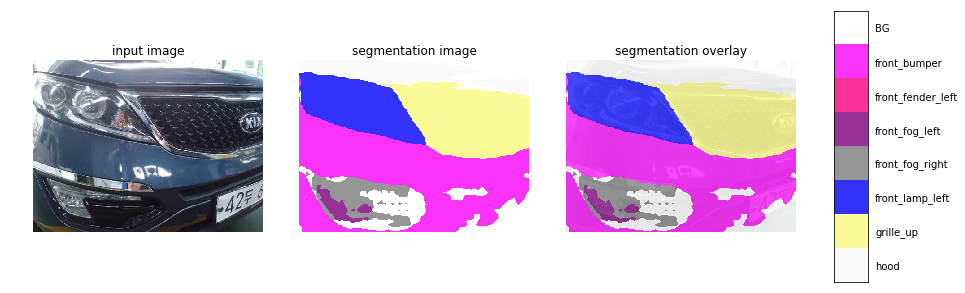

In [5]:
image_path = '/content/dohai90/car_mask_data/0820/kgy/12/images/01202_0001_Background.jpg'
original_image = Image.open(image_path, 'r')

print('Running deeplab on image {}'.format(os.path.basename(image_path)))
resized_img, seg_map = MODEL.run(original_image)
vis_segmentation(resized_img, seg_map)